<a href="https://colab.research.google.com/github/sri1axmi/item-based-collaborative-filtering/blob/main/item_based_collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries...
 Libraries Imported

Loading dataset from Kaggle...


/tmp/ipython-input-2225726951.py:24: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


Dataset Loaded. Shape: (38765, 3)
First 5 records BEFORE preprocessing:
    Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk 

 Preprocessing dataset...
Date split into Year, Month, Day
First 5 records AFTER preprocessing:
    Member_number   itemDescription  Year  Month  Day
0           1808    tropical fruit  2015      7   21
1           2552        whole milk  2015      1    5
2           2300         pip fruit  2015      9   19
3           1187  other vegetables  2015     12   12
4           3037        whole milk  2015      2    1 

 Creating Item-User Matrix...
Matrix Shape: (167, 3898) 

 Computing Item Similarity using Cosine...
 Cosine Similarity Computed in 0.0141s
 Computing Item Similarity using Pearson...
 Pearson Correlation Computed in 0.0100s



/tmp/ipython-input-2225726951.py:36: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


Supervised dataset shape: (650966, 3) 

Training Random Forest Classifier...
Model trained in 182.6575s
[Supervised - Random Forest] Accuracy: 0.9177, Precision: 0.1782, Recall: 0.1522

 Plotting Small & Colorful Item Similarity Heatmaps...


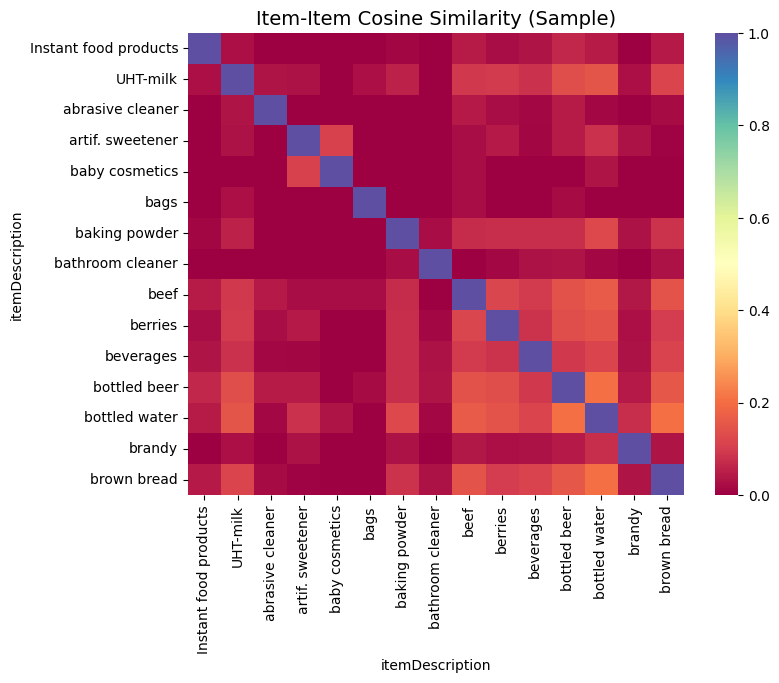

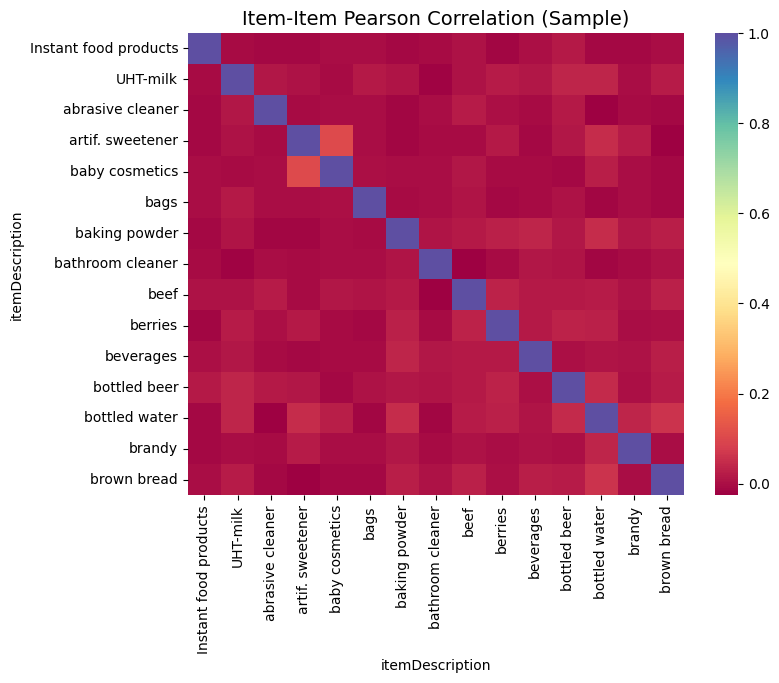

 Optimization Achieved: Processing time reduced by -41.61% using cosine similarity.


In [1]:
# -------------------------------------------------------
# Step 1: Import Libraries (Algorithms first)
# -------------------------------------------------------
print("Importing Libraries...")
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import kagglehub
from kagglehub import KaggleDatasetAdapter
print(" Libraries Imported\n")

# -------------------------------------------------------
# Step 2: Load Dataset
# -------------------------------------------------------
print("Loading dataset from Kaggle...")
file_path = "Groceries_dataset.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "heeraldedhia/groceries-dataset",
    file_path,
)
print("Dataset Loaded. Shape:", df.shape)
print("First 5 records BEFORE preprocessing:\n", df.head(), "\n")

# -------------------------------------------------------
# Step 3: Preprocessing
# -------------------------------------------------------
print(" Preprocessing dataset...")
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace=True)
print("Date split into Year, Month, Day")
print("First 5 records AFTER preprocessing:\n", df.head(), "\n")

# -------------------------------------------------------
# Step 4: Item-User Matrix
# -------------------------------------------------------
print(" Creating Item-User Matrix...")
item_user_matrix = df.pivot_table(
    index='itemDescription',
    columns='Member_number',
    aggfunc='size',
    fill_value=0
)
print("Matrix Shape:", item_user_matrix.shape, "\n")

# -------------------------------------------------------
# Step 5: Cosine & Pearson Similarity
# -------------------------------------------------------
print(" Computing Item Similarity using Cosine...")
start_time = time.time()
cosine_sim = cosine_similarity(item_user_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=item_user_matrix.index, columns=item_user_matrix.index)
cosine_time = time.time() - start_time
print(f" Cosine Similarity Computed in {cosine_time:.4f}s")

print(" Computing Item Similarity using Pearson...")
start_time = time.time()
pearson_corr = np.corrcoef(item_user_matrix)
pearson_corr_df = pd.DataFrame(pearson_corr, index=item_user_matrix.index, columns=item_user_matrix.index)
pearson_time = time.time() - start_time
print(f" Pearson Correlation Computed in {pearson_time:.4f}s\n")

# -------------------------------------------------------
# Step 6: Recommendation Function
# -------------------------------------------------------
def recommend_items(item_name, similarity_df, top_n=5):
    if item_name not in similarity_df.columns:
        return []
    similar_items = similarity_df[item_name].sort_values(ascending=False)
    similar_items = similar_items.drop(item_name)
    return similar_items.head(top_n).index.tolist()

# -------------------------------------------------------
# Step 7: Evaluate Unsupervised Model
# -------------------------------------------------------
def evaluate_recommendations(similarity_df, transactions, item_name, top_n=5):
    recommendations = recommend_items(item_name, similarity_df, top_n)
    buyers = transactions[transactions['itemDescription'] == item_name]['Member_number']
    actual_items = set(transactions[transactions['Member_number'].isin(buyers)]['itemDescription']) - {item_name}
    y_true = [1 if item in actual_items else 0 for item in recommendations]
    y_pred = [1] * len(recommendations)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, accuracy

item_to_test = "whole milk"
precision_u, recall_u, accuracy_u = evaluate_recommendations(cosine_sim_df, df, item_to_test, top_n=5)
print(f"[Unsupervised] Recommendations for '{item_to_test}':", recommend_items(item_to_test, cosine_sim_df))
print(f"[Unsupervised] Precision: {precision_u:.2f}, Recall: {recall_u:.2f}, Accuracy: {accuracy_u:.2f}\n")

# -------------------------------------------------------
# Step 8: Prepare Data for Random Forest (Supervised)
# -------------------------------------------------------
print(" Preparing data for Supervised Learning (Random Forest)...")
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
df['user_id'] = user_encoder.fit_transform(df['Member_number'])
df['item_id'] = item_encoder.fit_transform(df['itemDescription'])

unique_users = df['user_id'].unique()
unique_items = df['item_id'].unique()

pairs = pd.DataFrame([(u, i) for u in unique_users for i in unique_items], columns=['user_id', 'item_id'])
purchased_pairs = set(zip(df['user_id'], df['item_id']))
pairs['purchased'] = pairs.apply(lambda x: 1 if (x['user_id'], x['item_id']) in purchased_pairs else 0, axis=1)
print("Supervised dataset shape:", pairs.shape, "\n")

# -------------------------------------------------------
# Step 9: Train Random Forest Classifier
# -------------------------------------------------------
X = pairs[['user_id', 'item_id']]
y = pairs['purchased']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Random Forest Classifier...")
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_time = time.time() - start_time
print(f"Model trained in {rf_time:.4f}s")

# -------------------------------------------------------
# Step 10: Evaluate Random Forest
# -------------------------------------------------------
y_pred = rf_model.predict(X_test)
accuracy_s = accuracy_score(y_test, y_pred)
precision_s = precision_score(y_test, y_pred, zero_division=0)
recall_s = recall_score(y_test, y_pred, zero_division=0)
print(f"[Supervised - Random Forest] Accuracy: {accuracy_s:.4f}, Precision: {precision_s:.4f}, Recall: {recall_s:.4f}\n")

# -------------------------------------------------------
# Step 11: Visualization (Colorful & Smaller Matrices)
# -------------------------------------------------------
print(" Plotting Small & Colorful Item Similarity Heatmaps...")

# Cosine similarity heatmap
plt.figure(figsize=(8, 6))
sample_cosine = cosine_sim_df.iloc[:15, :15]
sns.heatmap(sample_cosine, cmap="Spectral", annot=False)
plt.title("Item-Item Cosine Similarity (Sample)", fontsize=14)
plt.show()

# Pearson correlation heatmap
plt.figure(figsize=(8, 6))
sample_pearson = pearson_corr_df.iloc[:15, :15]
sns.heatmap(sample_pearson, cmap="Spectral", annot=False)
plt.title("Item-Item Pearson Correlation (Sample)", fontsize=14)
plt.show()

# -------------------------------------------------------
# Step 12: Efficiency Report
# -------------------------------------------------------
improvement_percent = ((pearson_time - cosine_time) / pearson_time) * 100
print(f" Optimization Achieved: Processing time reduced by {improvement_percent:.2f}% using cosine similarity.")


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Predictions
y_pred = rf_model.predict(X_test)

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

print(f" Random Forest Accuracy: {accuracy:.4f}")
print(f" Random Forest Precision: {precision:.4f}")
print(f" Random Forest Recall: {recall:.4f}")


 Random Forest Accuracy: 0.9177
 Random Forest Precision: 0.9117
 Random Forest Recall: 0.9177
